# Harris Corner Detection
The Harris corner detector is a feature detector based on a 2D structure tensor.

The final equation, after a Taylor expansion and some simplification, is
$$
E(u, v) \approx \begin{bmatrix} u & v\end{bmatrix} M \begin{bmatrix} u \\ v\end{bmatrix},
$$
where 
$$
M = \sum_{x,y} w(x,y) \begin{bmatrix} I_xI_x & I_xI_y\\ I_yI_y & I_xI_y \end{bmatrix}.
$$

The window function $w(x,y)$ is typically a window with a Gaussian kernel.

### General Steps
- Convert image to grayscale
- Calculate Gaussian blur
- Calculate image derivatives
- Loop over pixels, create structure tensor
- Calculate Harris response
- Threshold responses

#### Convert image to grayscale
The `image = np.asarray(Image.open(image_path).convert('L'))` opens and converts an image to grayscale. Why do we convert RGB to grayscale?

Read in rice.png. Shape: (512, 512)


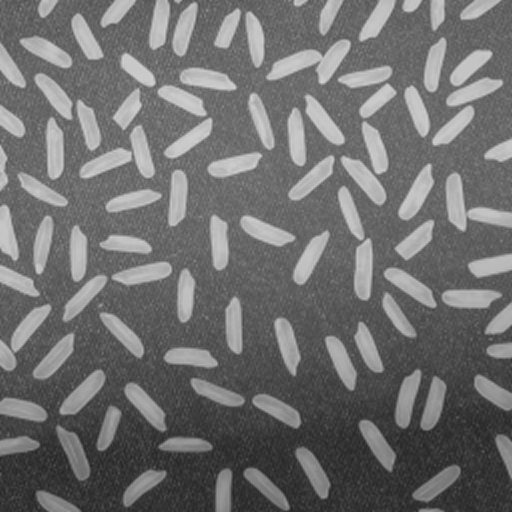

In [9]:
from PIL import Image
import numpy as np


image_path = 'rice.png'
# image_path = 'checker.jpg'

# Read in image as grayscale and store as an array
image = np.asarray(Image.open(image_path).convert('L'))
print(f'Read in {image_path}. Shape: {image.shape}')
width = image.shape[1]
height = image.shape[0]
Image.fromarray(image)

#### Gaussian blur and image derivatives
What's the purpose of using a Gaussian blur on an image? How does it help features?

The image derivatives can be calculated with sobel filters. Notice that the sobel filters are used after a Gaussian blur. Is there a faster way to convolve the image twice with two different filters?

In [10]:
from scipy.signal import convolve2d

def ConvImg(image: np.ndarray, filter: np.ndarray) -> np.ndarray:
    # Convolve image and normalize
    image = convolve2d(image, filter)
    image = (image - image.min()) * 255 / (image.max() - image.min())

    return image.astype(np.ubyte)

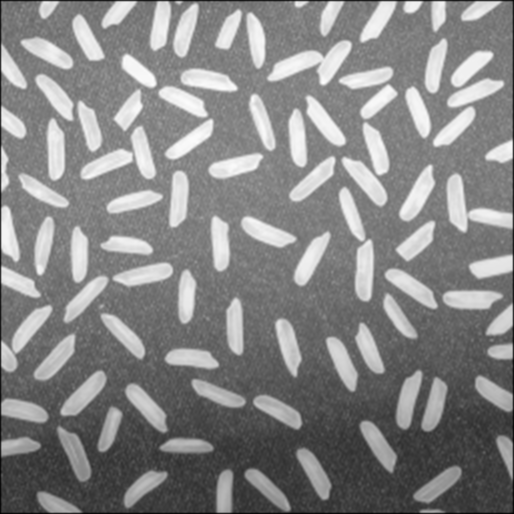

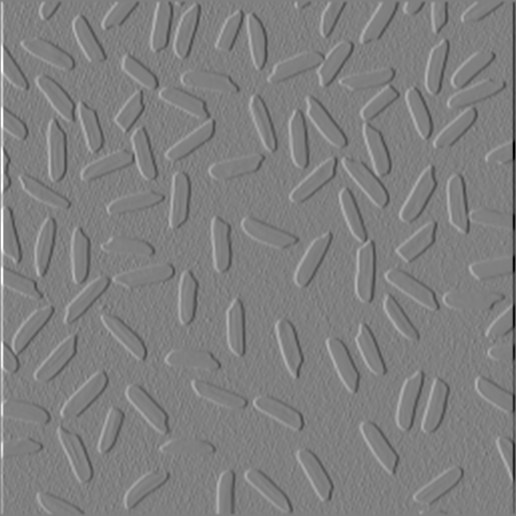

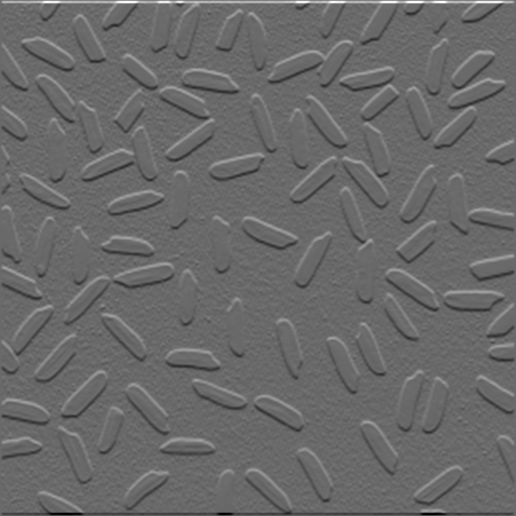

In [11]:
gauss = np.array([[1, 2, 1],
                  [2, 4, 2],
                  [1, 2, 1]]) * 1/16

sobel_x = np.array([[ 1,  0, -1],
                    [ 2,  0, -2],
                    [ 1,  0, -1]])

sobel_y = np.array([[ 1,  2,  1],
                    [ 0,  0,  0],
                    [-1, -2, -1]])

img_g = ConvImg(image, gauss)
display(Image.fromarray(img_g))

img_g_dx = ConvImg(img_g, sobel_x)
display(Image.fromarray(img_g_dx))

img_g_dy = ConvImg(img_g, sobel_y)
display(Image.fromarray(img_g_dy))

#### Set up structure tensor look-up tables

In [12]:
img_dxdx = np.multiply(img_g_dx, img_g_dx)
img_dydy = np.multiply(img_g_dy, img_g_dy)
# Do we need dydx too?
img_dxdy = np.multiply(img_g_dx, img_g_dy)

#### Harris detect function
- Uses a square window
- Ignores image edges
- Computes just the eigenvalues of the structure tensor
- Stores Harris response in a matrix

In [13]:
def HarrisDetect(img_dxdx: np.ndarray, img_dydy: np.ndarray, 
                 img_dxdy: np.ndarray, win_size: int = 1, 
                 step: int = 1, k: float = 0.04) -> np.ndarray:

    rows, cols = img_dxdx.shape
    radius = int((win_size - 1) / 2)

    R_response = np.zeros(img_dxdx.shape)

    for row in np.arange(0 + radius, rows - radius, step):
        for col in np.arange(0 + radius, cols - radius, step):
            window_rows = np.arange(row - radius, row + radius + 1)
            window_cols = np.arange(col - radius, col + radius + 1)

            # Mesh grid of indices
            window_idx = np.ix_(window_rows, window_cols)

            Ixx = np.sum(img_dxdx[window_idx].flatten())
            Iyy = np.sum(img_dydy[window_idx].flatten())
            Ixy = np.sum(img_dxdy[window_idx].flatten())
            tensor = np.array([[Ixx, Ixy],
                               [Ixy, Iyy]])

            eigenvals = np.linalg.eigvalsh(tensor)
            R_response[row, col] = (eigenvals[0] * eigenvals[1] - 
                                    k * ((Ixx + Iyy) ** 2))

    return R_response

##### What do the eigenvalues of a structure tensor tell us?
First, understand the theorem that if $A$ is an $n \times n$ symmetric matrix, then any two eigenvectors associated with distinct eigenvalues are orthogonal. Structure tensors are symmetric by definition, so as long as the eigenvalues are distinct, then the eigenvectors form a basis.

This basis represents the distribution of the gradient, with the eigenvalues representing the magnitude of the distribution of the gradient. Using this information, then the eigenvalues $\lambda_1, \lambda_2$ can be used to classify a pixel based on its window. When both $\lambda_1$ and $\lambda_2$ are large and approximately equal, then the gradient increases in both direction and forms a corner. When one eigenvalue is much larger than the other, $\lambda_1 \gg \lambda_2$ or $\lambda_2 \gg \lambda_1$, then the intensity predominantly increases in only one direction. Finally, if both $\lambda_1, \lambda_2$ are small, then the area is flat.

This is usually combined into the function
$$
R = \mathrm{det}(M) - k(\mathrm{trace}(M))^2,
$$
so that when $|R|$ is small, the area is flat; when $R < 0$, the area is an edge; and when $R$ is large, the region is a corner.

In [14]:
response = HarrisDetect(img_dxdx, img_dydy, img_dxdy, 1)

In [17]:
threshold = 0.75 * response.max()
n_responses = np.sum(response > threshold)

print(f'Threshold: {threshold}\nAmount: {n_responses}')
response_idx = np.asarray((response > threshold).nonzero())

Threshold: 25022.0
Amount: 1572


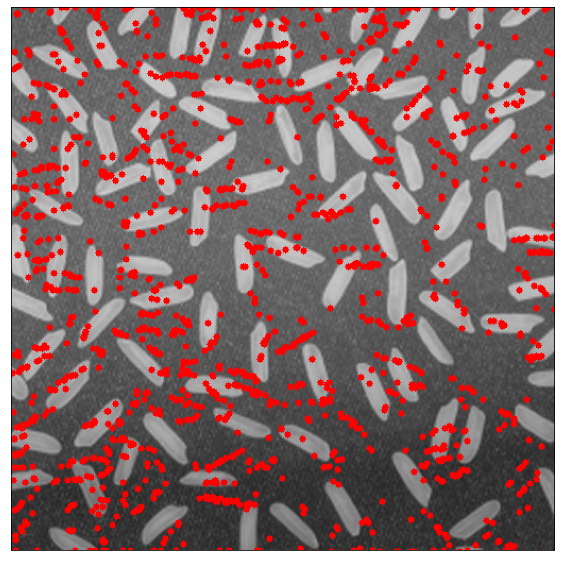

In [18]:
import cv2
from matplotlib import pyplot as plt

image_features = cv2.imread(image_path)
for i in np.arange(response_idx.shape[1]):
    image_features = cv2.circle(image_features, 
        (response_idx[0,i], response_idx[1,i]), 
        radius=3, color=(255,0,0), thickness=-1)

# Display image
plt.figure(figsize=(10,10))
plt.xticks([])
plt.yticks([])
plt.imshow(image_features)